In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import time
import os
from itertools import product
from pylab import rcParams
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess, Fourier

In [2]:
datafolder ='data/'
oil= pd.read_csv(os.path.join(datafolder,'oil.csv'))
holidays_events=pd.read_csv(os.path.join(datafolder,'holidays_events.csv'))
stores= pd.read_csv(os.path.join(datafolder,'stores.csv'))
train= pd.read_csv(os.path.join(datafolder,'train.csv'))
test= pd.read_csv(os.path.join(datafolder,'test.csv'))
transactions= pd.read_csv(os.path.join(datafolder,'transactions.csv'))

In [3]:
calendar = pd.DataFrame(index=pd.date_range('2013-01-01', '2017-08-31'))

# moving average
df_oil = pd.read_csv(datafolder + 'oil.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
df_oil['ma_oil'] = df_oil['dcoilwtico'].rolling(7).mean()

calendar = calendar.merge(df_oil, how='left', left_index=True, right_index=True)
calendar['ma_oil'].fillna(method='ffill', inplace=True)




In [4]:
calendar['dofw'] = calendar.index.dayofweek

In [5]:
df_events = pd.read_csv(datafolder + 'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
df_events['date'] = df_events['date'].replace({'2013-04-29' : 
                                         pd.to_datetime('2013-03-29')}) # 'Good Friday' mistake correction

df_events = df_events.set_index('date').sort_index()
df_events = df_events[df_events.locale == 'National'] 
df_events = df_events.groupby(df_events.index).first() # Keep one event only

In [6]:
df_events = pd.read_csv(datafolder + 'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
df_events['date'] = df_events['date'].replace({'2013-04-29' : 
                                         pd.to_datetime('2013-03-29')}) # 'Good Friday' mistake correction

df_events = df_events.set_index('date').sort_index()
df_events = df_events[df_events.locale == 'National'] 
df_events = df_events.groupby(df_events.index).first() # Keep one event only

In [7]:
calendar['wd'] = True

calendar.loc[calendar.dofw > 4, 'wd'] = False
calendar = calendar.merge(df_events, how='left', left_index=True, right_index=True)
calendar.loc[calendar.type == 'Bridge'  , 'wd'] = False
calendar.loc[calendar.type == 'Work Day', 'wd'] = True
calendar.loc[calendar.type == 'Transfer', 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = False
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True ), 'wd'] = True

In [8]:
df_train = pd.read_csv(datafolder + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)
df_train.date = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

df_test = pd.read_csv(datafolder + 'test.csv',
                      usecols=['store_nbr', 'family', 'date'],
                      dtype={'store_nbr': 'category', 'family': 'category'},
                      parse_dates=['date'], infer_datetime_format=True)
df_test.date = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [9]:
end_date='2017-08-15'
start_date='2017-04-01'

In [10]:
y = df_train.unstack(['store_nbr', 'family']).loc[start_date:end_date]

In [27]:
y

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-04-01        9.0       0.0    1.0    3229.0   0.0   526.249023   
2017-04-02        4.0       0.0    1.0    1210.0   0.0   180.339005   
2017-04-03       11.0       0.0    2.0    2097.0   0.0   444.856995   
2017-04-04        3.0       0.0    4.0    2249.0   1.0   403.819000   
2017-04-05        5.0       0.0    1.0    2687.0   2.0   499.385010   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-04-01        14.0    858.0  1151.0  243.272003  ...       3.0   
2017-04-02         3.0    281.0   446.0   86.641998  ...       4.0   
2017-04-03        11.0    801.0   794.0  166.119995  ...       3.0   
2017-04-04        19.0    673.0   725.0  149.078003  ...       0.0   
2017-04-05        18.0   1057.0  1074.0  216.742996  ...       1.0   
...                ...      ...     ...         ...  ...       ...   
2017-08-11         4.0    341.0   343.0   64.302002  ...       5.0   
2017-08-12         3.0    351.0   526.0   99.487999  ...       2.0   
2017-08-13         1.0    169.0   266.0   47.770000  ...       3.0   
2017-08-14         4.0    571.0   699.0  154.578003  ...      12.0   
2017-08-15        21.0    703.0   602.0  116.402000  ...      11.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-04-01  671.481018        1524.0         20.0                    24.0   
2017-04-02  513.000977         842.0         19.0                    29.0   
2017-04-03  481.912018         742.0          7.0                    14.0   
2017-04-04  290.717010         594.0          4.0                    15.0   
2017-04-05  410.497009         633.0          2.0                    20.0   
...                ...           ...          ...                     ...   
2017-08-11  309.244995         373.0         11.0                     2.0   
2017-08-12  260.298004         400.0          7.0                    10.0   
2017-08-13  327.205994         510.0          2.0                     9.0   
2017-08-14  330.975006         445.0          2.0                    14.0   
2017-08-15  449.227997         522.0          6.0                     6.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-04-01  851.388000     311.147003  2625.523926                        1.0   
2017-04-02  621.062012     229.181000  2303.476074                        3.0   
2017-04-03  532.640991     132.583008  1697.151001                        2.0   
2017-04-04  451.968994     127.585999  2506.139893                        2.0   
2017-04-05  395.341003      84.173996  1349.001953                        1.0   
...           

In [12]:


fourier = CalendarFourier(freq='W', order=4)
dp = DeterministicProcess(index=y.index,
                          constant=False,
                          order=1,
                          seasonal=False,
                          additional_terms=[fourier],
                          drop=True)
X = dp.in_sample()

# Extentions

X['oil']  = calendar.loc[start_date:end_date]['ma_oil'].values
X['dofw'] = calendar.loc[start_date:end_date]['dofw'].values
X['wd']   = calendar.loc[start_date:end_date]['wd'].values
X['type'] = calendar.loc[start_date:end_date]['type'].values

X = pd.get_dummies(X, columns=['dofw'], drop_first=True)
X = pd.get_dummies(X, columns=['type'], drop_first=False)

model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True) # try alpha,0.1 ,0.3 ,0.6 and 0.9
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

C:\Users\Tijs\anaconda3\envs\TS\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


In [13]:
y.columns

MultiIndex([('sales', '1',                 'AUTOMOTIVE'),
            ('sales', '1',                  'BABY CARE'),
            ('sales', '1',                     'BEAUTY'),
            ('sales', '1',                  'BEVERAGES'),
            ('sales', '1',                      'BOOKS'),
            ('sales', '1',               'BREAD/BAKERY'),
            ('sales', '1',                'CELEBRATION'),
            ('sales', '1',                   'CLEANING'),
            ('sales', '1',                      'DAIRY'),
            ('sales', '1',                       'DELI'),
            ...
            ('sales', '9',                  'MAGAZINES'),
            ('sales', '9',                      'MEATS'),
            ('sales', '9',              'PERSONAL CARE'),
            ('sales', '9',               'PET SUPPLIES'),
            ('sales', '9',    'PLAYERS AND ELECTRONICS'),
            ('sales', '9',                    'POULTRY'),
            ('sales', '9',             'PREPARED FOODS')

In [14]:
y_pred

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
date                                                                            
2017-04-01   5.013865       0.0  2.948485  2380.871836  0.277781   387.798988   
2017-04-02   2.378097       0.0  1.820444  1278.219266  0.361263   211.644880   
2017-04-03   4.307524       0.0  3.138380  2315.433984  0.504685   398.939468   
2017-04-04   3.989547       0.0  2.978586  2366.644092  0.535169   384.382313   
2017-04-05   4.017827       0.0  3.142907  2465.666416  0.763368   425.609468   
...               ...       ...       ...          ...       ...          ...   
2017-08-11   2.622676       0.0  1.317783  1378.552963 -0.014333   208.467472   
2017-08-12   5.344250       0.0  3.565205  2315.777580 -0.001691   349.093973   
2017-08-13   2.708482       0.0  2.437163  1213.125010  0.081791   172.939865   
2017-08-14   4.627288       0.0  3.820675  2254.953683  0.224955   361.255908   
2017-08-15   4.296427       0.0  3.740439  2311.761532  0.255127   347.938003   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
date                                                        ...             
2017-04-01   13.696529  635.363541  793.932138  142.689521  ...  4.265847   
2017-04-02    6.913911  328.940079  448.966094   82.422835  ...  5.408222   
2017-04-03   16.705131  700.474820  790.899066  149.401275  ...  3.793553   
2017-04-04   17.797831  764.413596  765.534565  144.025427  ...  4.178054   
2017-04-05   17.068902  847.524084  878.972666  152.037757  ...  3.696831   
...                ...         ...         ...         ...  ...       ...   
2017-08-11    8.925260  407.197542  441.136949   93.059899  ...  4.428245   
2017-08-12   10.848275  584.568867  704.479240  131.882156  ...  3.639521   
2017-08-13    4.065656  278.145405  359.513196   71.615470  ...  4.781895   
2017-08-14   14.040552  653.589838  702.870284  138.772747  ...  3.113319   
2017-08-15   15.356091  722.271929  679.233547  133.613868  ...  3.432419   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-04-01  427.602856    662.908192    10.111140               17.410911   
2017-04-02  460.670757    687.744475    10.306991               18.001881   
2017-04-03  380.106185    517.242907     7.567960               13.507564   
2017-04-04  368.634502    503.060912     6.354861               12.716406   
2017-04-05  337.880780    440.491000     6.959606               13.209357   
...                ...           ...          ...                     ...   
2017-08-11  333.920471    374.015676     9.267352                5.302480   
2017-08-12  402.072487    593.689439    10.043545               12.237983   
2017-08-13  435.140389    618.525723    10.239396               12.828954   
2017-08-14  355.514834    446.403719     7.524298                8.094243   
2017-08-15  345.182385    430.255779     6.340234                7.011435   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-04-01  540.152978     158.366445  1856.488676                 -15.880737   
2017-04-02  600.880125     154.423251  2145.080362                  -8.820549   
20

In [15]:
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
y_target['sales_pred'] = y_pred['sales'].clip(0.) 
y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.259202
BABY CARE                     0.066660
BEAUTY                        0.267450
BEVERAGES                     0.199187
BOOKS                         0.026701
BREAD/BAKERY                  0.125449
CELEBRATION                   0.295910
CLEANING                      0.204513
DAIRY                         0.136196
DELI                          0.108830
EGGS                          0.147672
FROZEN FOODS                  0.145027
GROCERY I                     0.210306
GROCERY II                    0.347753
HARDWARE                      0.273930
HOME AND KITCHEN I            0.259483
HOME AND KITCHEN II           0.219104
HOME APPLIANCES               0.154737
HOME CARE                     0.122103
LADIESWEAR                    0.259483
LAWN AND GARDEN               0.216374
LINGERIE                      0.400216
LIQUOR,WINE,BEER              0.612719
MAGAZINES                     0.254086
MEATS                         0.123141
PERSONAL CARE     

<AxesSubplot:xlabel='date'>

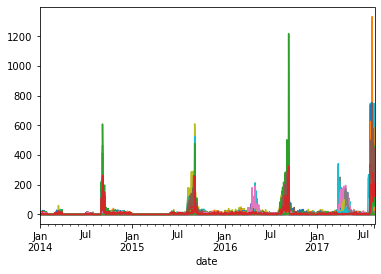

In [16]:
df_train.unstack(['store_nbr', 'family']).loc['2014':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)

In [17]:
from joblib import Parallel, delayed
import warnings

from sklearn.linear_model import Ridge
from sklearn.ensemble     import RandomForestRegressor

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':
            
            model = RandomForestRegressor(n_estimators = 300, n_jobs=-1, random_state=1)
            
        else:
            
            model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)
            
        model.fit(X, y)

        return model

    def fit(self, X, y):

        self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                              verbose=self.verbose,
                              )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        
        return
    
    def predict(self, X):
        
        y_pred = Parallel(n_jobs=self.n_jobs, 
                          verbose=self.verbose)(delayed(e.predict)(X) for e in self.estimators_)
        
        return np.stack(y_pred, axis=1)

In [18]:
model = CustomRegressor(n_jobs=-1, verbose=0)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [19]:
y_pred   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
y_target['sales_pred'] = y_pred['sales'].clip(0.) 
y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

family
AUTOMOTIVE                    0.259202
BABY CARE                     0.066660
BEAUTY                        0.267450
BEVERAGES                     0.199187
BOOKS                         0.026701
BREAD/BAKERY                  0.125449
CELEBRATION                   0.295910
CLEANING                      0.204513
DAIRY                         0.136196
DELI                          0.108830
EGGS                          0.147672
FROZEN FOODS                  0.145027
GROCERY I                     0.210306
GROCERY II                    0.347753
HARDWARE                      0.273930
HOME AND KITCHEN I            0.259483
HOME AND KITCHEN II           0.219104
HOME APPLIANCES               0.154737
HOME CARE                     0.122103
LADIESWEAR                    0.259483
LAWN AND GARDEN               0.216374
LINGERIE                      0.400216
LIQUOR,WINE,BEER              0.612719
MAGAZINES                     0.254086
MEATS                         0.123141
PERSONAL CARE     

In [20]:
end_test='2017-08-31'
start_test='2017-08-16'
X_test = dp.out_of_sample(steps=16)

# Extentions
X_test['oil']  = calendar.loc[start_test:end_test]['ma_oil'].values
X_test['dofw'] = calendar.loc[start_test:end_test]['dofw'].values
X_test['wd']   = calendar.loc[start_test:end_test]['wd'].values

X_test = pd.get_dummies(X_test, columns=['dofw'], drop_first=True)

# No national level events in this period
X_test[['type_Additional', 'type_Event', 'type_Holiday', 'type_Transfer']] = 0

sales_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
sales_pred = sales_pred.stack(['store_nbr', 'family'])
sales_pred[sales_pred < 0] = 0. 

In [21]:
y.columns

MultiIndex([('sales', '1',                 'AUTOMOTIVE'),
            ('sales', '1',                  'BABY CARE'),
            ('sales', '1',                     'BEAUTY'),
            ('sales', '1',                  'BEVERAGES'),
            ('sales', '1',                      'BOOKS'),
            ('sales', '1',               'BREAD/BAKERY'),
            ('sales', '1',                'CELEBRATION'),
            ('sales', '1',                   'CLEANING'),
            ('sales', '1',                      'DAIRY'),
            ('sales', '1',                       'DELI'),
            ...
            ('sales', '9',                  'MAGAZINES'),
            ('sales', '9',                      'MEATS'),
            ('sales', '9',              'PERSONAL CARE'),
            ('sales', '9',               'PET SUPPLIES'),
            ('sales', '9',    'PLAYERS AND ELECTRONICS'),
            ('sales', '9',                    'POULTRY'),
            ('sales', '9',             'PREPARED FOODS')

In [22]:
X_test

,trend,"sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",oil,wd,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Event,type_Holiday,type_Transfer
2017-08-16,138.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,48.281429,True,0,1,0,0,0,0,0,0,0,0
2017-08-17,139.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.995714,True,0,0,1,0,0,0,0,0,0,0
2017-08-18,140.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.852857,True,0,0,0,1,0,0,0,0,0,0
2017-08-19,141.0,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490,47.852857,False,0,0,0,0,1,0,0,0,0,0
2017-08-20,142.0,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969,47.852857,False,0,0,0,0,0,1,0,0,0,0
2017-08-21,143.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,47.688571,True,0,0,0,0,0,0,0,0,0,0
2017-08-22,144.0,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,47.522857,True,1,0,0,0,0,0,0,0,0,0
2017-08-23,145.0,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,47.645714,True,0,1,0,0,0,0,0,0,0,0
2017-08-24,146.0,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,47.598571,True,0,0,1,0,0,0,0,0,0,0
2017-08-25,147.0,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,47.720000,True,0,0,0,1,0,0,0,0,0,0


In [23]:
sales_pred

sales
           store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                     4.309557
                     BABY CARE                      0.000000
                     BEAUTY                         3.998301
                     BEVERAGES                   2417.365382
                     BOOKS                          0.482959
...                                                      ...
2017-08-31 9         POULTRY                      336.982537
                     PREPARED FOODS                93.747146
                     PRODUCE                     1267.738442
                     SCHOOL AND OFFICE SUPPLIES   142.120000
                     SEAFOOD                       14.324872

[28512 rows x 1 columns]

In [24]:
sales_pred.values

array([[   4.30955739],
       [   0.        ],
       [   3.99830094],
       ...,
       [1267.73844193],
       [ 142.12      ],
       [  14.32487218]])

In [25]:
My_submission = pd.read_csv(datafolder + 'sample_submission.csv', index_col='id')
My_submission.sales = sales_pred.values
My_submission.to_csv('submission.csv', index=True)

In [26]:
My_submission

,sales
id,
3000888,4.309557
3000889,0.000000
3000890,3.998301
3000891,2417.365382
3000892,0.482959
...,...
3029395,336.982537
3029396,93.747146
3029397,1267.738442
